## Load necessary libraries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Torchvision and related modules
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

# Torch utilities
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
import torch.optim as optim
import torch.nn as nn

## 1. Load and Normalize the Data

In [2]:
# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with mean and std for each channel
])

# Download and load the training set with transformations
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2
)

# Download and load the test set with transformations
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=False, num_workers=2
)

# Define class labels for reference
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Data Visualization

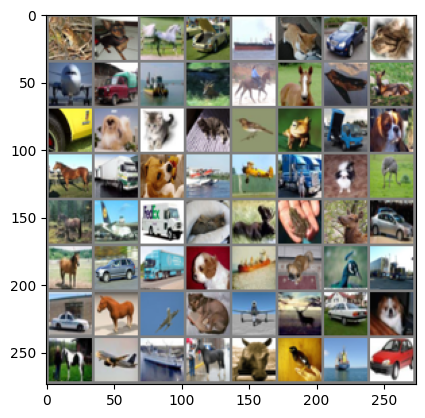

 frog   dog horse   car


In [3]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  
    plt.show()

# Get some random training images
dataiter = iter(trainloader)  
images, labels = next(dataiter)  

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


### Data Augmentation

In [4]:
# Advanced data augmentation specifically for training set
transform_train_augmented = transforms.Compose([
    transforms.RandomHorizontalFlip(),  
    transforms.RandomCrop(32, padding=4),  
    transforms.RandomRotation(15),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize pixel values
])

transform_val_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the dataset for training with new data augmentation
trainset_augmented = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_augmented)

# Split training set into train and validation sets
train_size = int(0.8 * len(trainset_augmented))  # 80% training, 20% validation
val_size = len(trainset_augmented) - train_size
trainset, valset = random_split(trainset_augmented, [train_size, val_size])

# Load test set 
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_val_test)

# Create data loaders for the augmented training set and validation/test sets
trainloader_augmented = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# CIFAR-10 classes (unchanged)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 2. Build the models

### 2.1 ResNet-18 Model 

In [5]:
# Device configuration (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the ResNet-18 model without pretrained weights
resnet18 = models.resnet18(pretrained=False)

num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)

# Move the model to the device (GPU or CPU)
resnet18 = resnet18.to(device)

# Print summary of the model
summary(resnet18, input_size=(3, 32, 32))  


C:\Users\21 Technology\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\21 Technology\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

### Define Loss Function and Optimizer

In [6]:
# Define the loss function
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(resnet18.parameters(), lr=0.001, weight_decay=1e-4)  


### Training and Validation Loop for Resnet-18

In [7]:
# Initialize variables for tracking the best model
best_val_accuracy = 0.0  
best_model_state = None  

epoch_num = 10  

# Lists to store training and validation loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epoch_num):
    running_loss = 0.0
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    resnet18.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        total_train_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        if i % 2000 == 1999:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_train_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    resnet18.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Calculate average validation loss and accuracy for the epoch
    avg_val_loss = total_val_loss / len(testloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Check if this epoch has the best validation accuracy so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = resnet18.state_dict()  # Save the best model weights

    print(f'Epoch [{epoch+1}/{epoch_num}] - '
          f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Save the best model state to a file
torch.save(best_model_state, "best_resnet18_cifar10.pth")
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")
print('Finished Training')

Epoch [1/10] - Train Loss: 1.3819, Train Accuracy: 50.60%, Validation Loss: 1.1020, Validation Accuracy: 61.54%
Epoch [2/10] - Train Loss: 0.9808, Train Accuracy: 65.79%, Validation Loss: 0.9975, Validation Accuracy: 66.12%
Epoch [3/10] - Train Loss: 0.8248, Train Accuracy: 71.18%, Validation Loss: 0.8342, Validation Accuracy: 71.15%
Epoch [4/10] - Train Loss: 0.6975, Train Accuracy: 75.70%, Validation Loss: 0.8308, Validation Accuracy: 71.73%
Epoch [5/10] - Train Loss: 0.6124, Train Accuracy: 78.81%, Validation Loss: 0.7378, Validation Accuracy: 74.96%
Epoch [6/10] - Train Loss: 0.5261, Train Accuracy: 81.61%, Validation Loss: 0.7735, Validation Accuracy: 74.23%
Epoch [7/10] - Train Loss: 0.4545, Train Accuracy: 84.25%, Validation Loss: 0.7730, Validation Accuracy: 75.07%
Epoch [8/10] - Train Loss: 0.3811, Train Accuracy: 86.91%, Validation Loss: 0.8154, Validation Accuracy: 73.89%
Epoch [9/10] - Train Loss: 0.3238, Train Accuracy: 88.77%, Validation Loss: 0.8139, Validation Accuracy:

### Plotting the Loss and Accuracy Curves of ResNet-18 Model

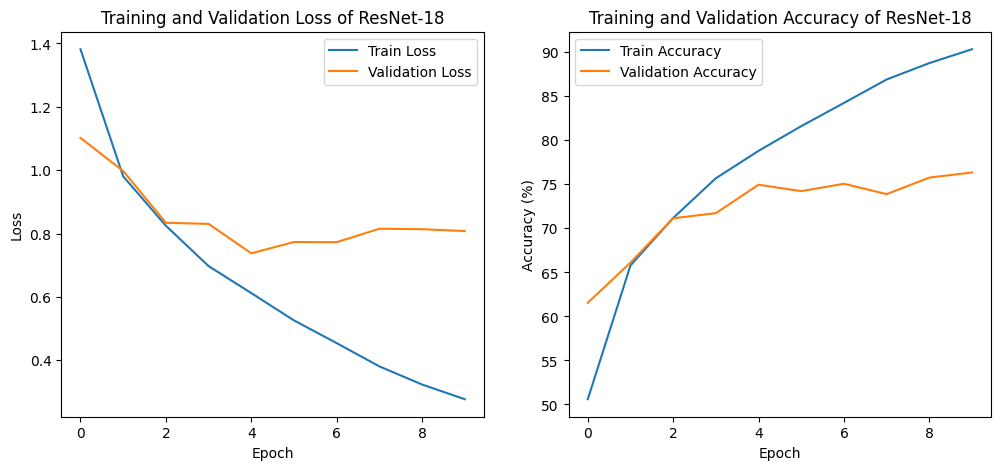

In [8]:
# Plotting the training and validation loss curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of ResNet-18')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy of ResNet-18')
plt.legend()

plt.show()

## 2.2  AlexNet Model

In [9]:
# Define a modified AlexNet for CIFAR-10 

class AlexNetForCIFAR10(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetForCIFAR10, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            nn.Conv2d(64, 192, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  

            nn.Conv2d(192, 384, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),  
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),  
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  
        x = self.classifier(x)
        return x

# Instantiate the model and move it to the device
alexnet = AlexNetForCIFAR10(num_classes=10).to(device)

# Show summary of the model
summary(alexnet, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           1,792
              ReLU-2           [-1, 64, 16, 16]               0
         MaxPool2d-3             [-1, 64, 8, 8]               0
            Conv2d-4            [-1, 192, 8, 8]         110,784
              ReLU-5            [-1, 192, 8, 8]               0
         MaxPool2d-6            [-1, 192, 4, 4]               0
            Conv2d-7            [-1, 384, 4, 4]         663,936
              ReLU-8            [-1, 384, 4, 4]               0
            Conv2d-9            [-1, 256, 4, 4]         884,992
             ReLU-10            [-1, 256, 4, 4]               0
           Conv2d-11            [-1, 256, 4, 4]         590,080
             ReLU-12            [-1, 256, 4, 4]               0
        MaxPool2d-13            [-1, 256, 2, 2]               0
          Dropout-14                 [-

### Loss Function and Optimizer

In [10]:
# Define the loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer with weight decay)
optimizer = optim.Adam(alexnet.parameters(), lr=0.001, weight_decay=1e-4)

### Training and Validation Loop for AlexNet Model

In [11]:
# Initialize the best accuracy tracking
best_val_accuracy = 0.0
best_model_state = None

epoch_num = 10  

# Lists to store training and validation loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epoch_num):
    running_loss = 0.0
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    alexnet.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        total_train_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        if i % 2000 == 1999:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_train_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    alexnet.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = alexnet(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Calculate average validation loss and accuracy for the epoch
    avg_val_loss = total_val_loss / len(testloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Check if this epoch has the best validation accuracy so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = alexnet.state_dict()  # Save the best model weights

    print(f'Epoch [{epoch+1}/{epoch_num}] - '
          f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Save the best model state to a file
torch.save(best_model_state, "best_alexnet_cifar10.pth")
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")
print('Finished Training')

Epoch [1/10] - Train Loss: 1.6462, Train Accuracy: 37.02%, Validation Loss: 1.3744, Validation Accuracy: 49.33%
Epoch [2/10] - Train Loss: 1.2729, Train Accuracy: 54.27%, Validation Loss: 1.1340, Validation Accuracy: 59.64%
Epoch [3/10] - Train Loss: 1.0814, Train Accuracy: 61.68%, Validation Loss: 1.0599, Validation Accuracy: 63.62%
Epoch [4/10] - Train Loss: 0.9542, Train Accuracy: 66.55%, Validation Loss: 1.0476, Validation Accuracy: 63.73%
Epoch [5/10] - Train Loss: 0.8588, Train Accuracy: 70.41%, Validation Loss: 0.9178, Validation Accuracy: 69.30%
Epoch [6/10] - Train Loss: 0.7764, Train Accuracy: 73.64%, Validation Loss: 0.9286, Validation Accuracy: 68.67%
Epoch [7/10] - Train Loss: 0.7127, Train Accuracy: 75.75%, Validation Loss: 0.8853, Validation Accuracy: 70.05%
Epoch [8/10] - Train Loss: 0.6465, Train Accuracy: 77.91%, Validation Loss: 0.9327, Validation Accuracy: 70.23%
Epoch [9/10] - Train Loss: 0.5977, Train Accuracy: 79.64%, Validation Loss: 0.9071, Validation Accuracy:

### Plot Loss and Accuracy Curves of AlexNet Model

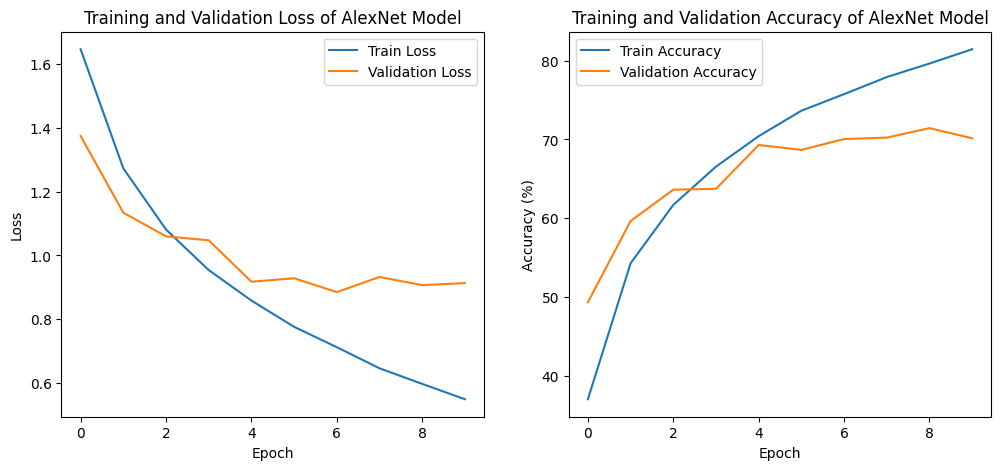

In [12]:
# Plotting the training and validation loss and accuracy curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of AlexNet Model')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy of AlexNet Model')
plt.legend()

plt.show()

## 2.3 MobileNet Model

In [13]:
# Load the MobileNetV2 model without pretrained weights
mobilenet = models.mobilenet_v2(pretrained=False)

mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 10)

# Move the model to the device (GPU or CPU)
mobilenet = mobilenet.to(device)

# Show summary of the model
summary(mobilenet, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
             ReLU6-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
             ReLU6-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 16, 16, 16]             512
       BatchNorm2d-8           [-1, 16, 16, 16]              32
  InvertedResidual-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 96, 16, 16]           1,536
      BatchNorm2d-11           [-1, 96, 16, 16]             192
            ReLU6-12           [-1, 96, 16, 16]               0
           Conv2d-13             [-1, 96, 8, 8]             864
      BatchNorm2d-14             [-1, 9

### Define Loss Function and Optimizer

In [14]:
# Define the loss function (CrossEntropyLoss for classification)
criterion = nn.CrossEntropyLoss()

# Define the optimizer (Adam optimizer with weight decay)
optimizer = optim.Adam(mobilenet.parameters(), lr=0.001, weight_decay=1e-4)

### Training and Validation Loop for MobileNet Model

In [17]:
# Initialize the best accuracy tracking
best_val_accuracy = 0.0
best_model_state = None

epoch_num = 10 

# Lists to store training and validation loss and accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epoch_num):
    running_loss = 0.0
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training phase
    mobilenet.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = mobilenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()
        total_train_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

        if i % 2000 == 1999:
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    # Calculate average training loss and accuracy for the epoch
    avg_train_loss = total_train_loss / len(trainloader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    mobilenet.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mobilenet(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Calculate average validation loss and accuracy for the epoch
    avg_val_loss = total_val_loss / len(testloader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Check if this epoch has the best validation accuracy so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state = mobilenet.state_dict()  # Save the best model weights

    print(f'Epoch [{epoch+1}/{epoch_num}] - '
          f'Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Save the best model state to a file
torch.save(best_model_state, "best_mobilenet_cifar10.pth")
print(f"Best Validation Accuracy: {best_val_accuracy:.2f}%")
print('Finished Training')

Epoch [1/10] - Train Loss: 1.0362, Train Accuracy: 63.76%, Validation Loss: 1.0328, Validation Accuracy: 63.97%
Epoch [2/10] - Train Loss: 0.9556, Train Accuracy: 66.99%, Validation Loss: 1.0032, Validation Accuracy: 65.39%
Epoch [3/10] - Train Loss: 0.8880, Train Accuracy: 69.37%, Validation Loss: 0.9553, Validation Accuracy: 66.89%
Epoch [4/10] - Train Loss: 0.8228, Train Accuracy: 71.45%, Validation Loss: 0.9195, Validation Accuracy: 68.28%
Epoch [5/10] - Train Loss: 0.7671, Train Accuracy: 73.62%, Validation Loss: 0.8459, Validation Accuracy: 70.39%
Epoch [6/10] - Train Loss: 0.7204, Train Accuracy: 75.17%, Validation Loss: 0.8157, Validation Accuracy: 71.66%
Epoch [7/10] - Train Loss: 0.6818, Train Accuracy: 76.75%, Validation Loss: 0.7757, Validation Accuracy: 72.85%
Epoch [8/10] - Train Loss: 0.6412, Train Accuracy: 78.06%, Validation Loss: 0.7847, Validation Accuracy: 72.77%
Epoch [9/10] - Train Loss: 0.6108, Train Accuracy: 78.91%, Validation Loss: 0.7960, Validation Accuracy:

### Plot Loss and Accuracy Curves of MobileNet Model

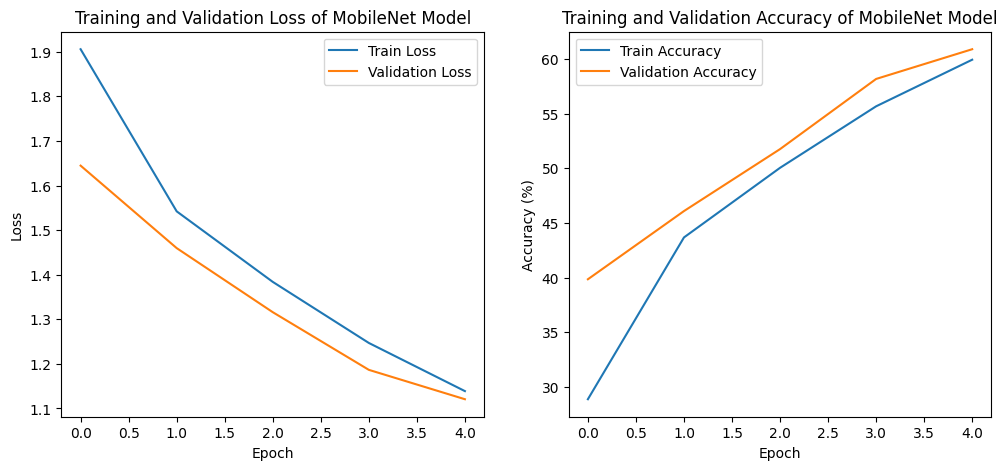

In [16]:
# Plotting the training and validation loss and accuracy curves

plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss of MobileNet Model')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy of MobileNet Model')
plt.legend()

plt.show()